In [1]:
import Heston
import BlackScholes as bs
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import ImpliedDrift as iD
import time

from matplotlib import cm

In [2]:
# Read the dataset
spot = np.array(pd.read_csv("spot.csv").Spot).flatten()
index = 0; S0 = spot[index];

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = S0 * moneyness / 100

rho = -0.8099208981919184
theta = 1.0864083431517277
kappa = 3.111291551927008
eta = 0.06297461024979689
sigma_0 = 0.03504626144419665

In [3]:
N = 64; L = 12;
r = iD.r(maturities, index); q = iD.q(maturities, index);
m = len(K); n =len(maturities);
options_type = K > S0

iv = np.zeros([n,m])
for i in range(n):
    tau = maturities[i]
    precomp_term, a, b = Heston.precomputed_terms(r[i], q[i], tau, sigma_0, kappa, eta, theta, rho, L, N)
    P = Heston.cos_method_Heston_LF(precomp_term, a, b, tau, r[i], q[i], sigma_0, kappa, eta, theta, rho, 
                                       S0, K, N, options_type, L)
    iv[i,:5] = bs.BSImpliedVol(S0, K[:5], tau, r[i], q[i], P[:5], 0, toll = 1e-3)
    iv[i,5:] = bs.BSImpliedVol(S0, K[5:], tau, r[i], q[i], P[5:], 1, toll = 1e-3)
    
err = np.mean(abs(IV-iv)/IV)*100

print(f"Mean relative percentage error: {err: .4f}%")

Mean relative percentage error:  4.5024%


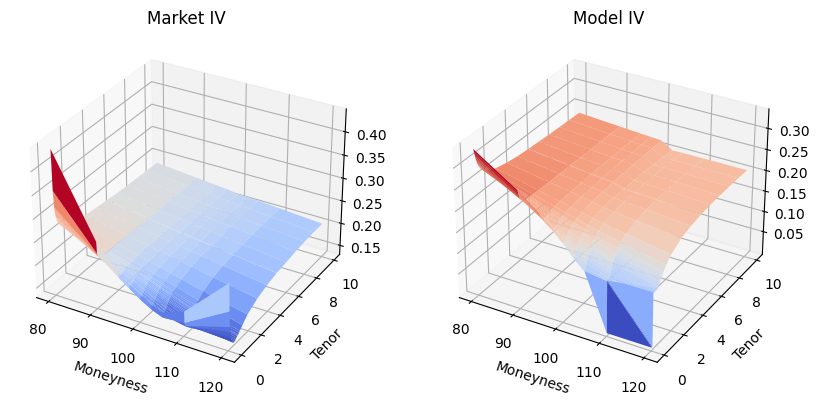

In [4]:
mesh_x, mesh_y = np.meshgrid(moneyness, maturities)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, iv, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Tenor')
ax2.set_title('Model IV')

plt.show()